# Clustering Project

In this project, I will be investigating the way people think about masculinity by applying the KMeans algorithm to data from  <a href="https://fivethirtyeight.com/" target = "_blank">FiveThirtyEight</a>. FiveThirtyEight is a popular website known for their use of statistical analysis in many of their stories.

To begin, take a look at `masculinity-survey.pdf`. FiveThirtyEight and WNYC studios used this survey to get their male readers' thoughts on masculinity. After looking through some of the questions asked, take a look at FiveThirtyEight's article <a href="https://fivethirtyeight.com/features/what-do-men-think-it-means-to-be-a-man/" target = "_blank">What Do Men Think It Means To Be A Man?</a> to see their major takeaways.

I am going to try to find more insights using machine learning.

In the code block below, I've loaded `masculinity.csv` into a DataFrame named `survey`. This file contains the raw responses to the masculinity survey. Let's start getting a sense of how this data is structured. First let's answer few questions using Pandas.
* What are the names of the columns? How do those columns relate to the questions in the PDF?
* How many rows are there?
* How is a question with multiple parts, like question 7, represented in the DataFrame?
* How many people said they often ask a friend for professional advice? This is the first sub-question in question 7.


In [2]:
import pandas as pd

survey = pd.read_csv("masculinity.csv")
print(survey.columns)
print(survey.shape)
print(len(survey))
print(survey['q0007_0011'].value_counts())
mans_who_often_ask_friend = len(survey[survey['q0007_0001'] == 'Often'])
print(f'Mans who often ask their friend for help: {number_often_ask_friend}')

Index(['Unnamed: 0', 'StartDate', 'EndDate', 'q0001', 'q0002', 'q0004_0001',
       'q0004_0002', 'q0004_0003', 'q0004_0004', 'q0004_0005', 'q0004_0006',
       'q0005', 'q0007_0001', 'q0007_0002', 'q0007_0003', 'q0007_0004',
       'q0007_0005', 'q0007_0006', 'q0007_0007', 'q0007_0008', 'q0007_0009',
       'q0007_0010', 'q0007_0011', 'q0008_0001', 'q0008_0002', 'q0008_0003',
       'q0008_0004', 'q0008_0005', 'q0008_0006', 'q0008_0007', 'q0008_0008',
       'q0008_0009', 'q0008_0010', 'q0008_0011', 'q0008_0012', 'q0009',
       'q0010_0001', 'q0010_0002', 'q0010_0003', 'q0010_0004', 'q0010_0005',
       'q0010_0006', 'q0010_0007', 'q0010_0008', 'q0011_0001', 'q0011_0002',
       'q0011_0003', 'q0011_0004', 'q0011_0005', 'q0012_0001', 'q0012_0002',
       'q0012_0003', 'q0012_0004', 'q0012_0005', 'q0012_0006', 'q0012_0007',
       'q0013', 'q0014', 'q0015', 'q0017', 'q0018', 'q0019_0001', 'q0019_0002',
       'q0019_0003', 'q0019_0004', 'q0019_0005', 'q0019_0006', 'q0019_0007',
      

NameError: name 'number_often_ask_friend' is not defined

# Mapping the Data

In order for us to start thinking about using the KMeans algorithm with this data, we need to first figure out how to turn these responses into numerical data. Let's once again consider question 7. We can't cluster the data using the phrases `"Often"` or `"Rarely"`, but we can turn those phrases into numbers. For example, we could map the data in the following way: 
* `"Often"` -> `4`
* `"Sometimes"` ->  `3`
* `"Rarely"` -> `2` 
* `"Never, but open to it"` -> `1`
* `"Never, and not open to it"` -> `0`.

Note that it's important that these responses are somewhat linear. `"Often"` is at one end of the spectrum with `"Never, and not open to it"` at the other. The other values fall in sequence between the two. I can perform similar mapping for the `"educ"` responses (question 29), but there isn't an obvious linear progression in the `"race"` responses (question 28).

In order to do this transformation, I use the `map()` function.

In [ ]:
cols_to_map = ["q0007_0001", "q0007_0002", "q0007_0003", "q0007_0004",
       "q0007_0005", "q0007_0006", "q0007_0007", "q0007_0008", "q0007_0009",
       "q0007_0010", "q0007_0011"]
for column in cols_to_map:
       survey[column] = survey[column].map({"Often":4, 'Sometimes':3, 'Rarely':2, 'Never, but open to it' : 1, 'Never, and not open to it':0})

print(survey['q0007_0011'].value_counts())

2.0    456
3.0    339
0.0    187
4.0    111
1.0     75
Name: q0007_0011, dtype: int64


# Plotting the Data

Now there are 11 different features that I can use in our KMeans algorithm. Before I jump into clustering, let's graph some of these features on a 2D graph. Call `plt.scatter` using `survey["q0007_0001"]` and `survey["q0007_0002"]` as parameters. Include `alpha = 0.1`. We want to include `alpha` because many of the data points will be on top of each other. Adding `alpha` will make the points appear more solid if there are many stacked on top of each other.

The x-axis corresponds with the first column in `scatter()` function. So in this case, it corresponds to the question about asking a friend for professional advice.

It make sense that there are few points in the top left and bottom right corners of the graph. Following our intuition, if person often ask friend for personal advice, we can assume he will also be likely to ask friend for professional advice and vice versa. 


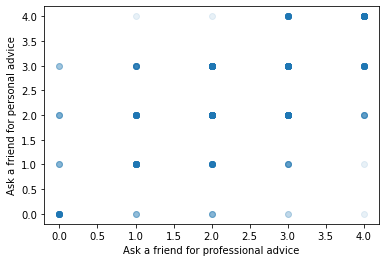

In [ ]:
from matplotlib import pyplot as plt
plt.scatter(survey['q0007_0001'], survey['q0007_0002'], alpha=0.1)
plt.xlabel("Ask a friend for professional advice")
plt.ylabel("Ask a friend for personal advice")
plt.savefig('Question7_0001_and_0002.jpg')
plt.show()

# Build the KMeans Model

It's now time to start clustering! Let's start by seeing if clusters form based on traditionally masculine concepts. 

Take a look at the first four sub-questions in question 7. Those four activities aren't necessarily seen as traditionally masculine. On the other hand, sub-questions 5, 8, and 9 are often seen as very masculine activities. What would happen if we found 2 clusters based on those 7 questions? Would we find clusters that represent traditionally feminine and traditionally masculine people? Let's find out.


Create a `KMeans` object named `classifier` where `n_clusters = 2`. Call `classifier`'s `.fit()` method. The parameter of `.fit()` should be the 7 columns we're interested in. For example, the following line of code will fit the model based on the columns `"col_one"` and `"col_two"` of the Dataframe `df`. 

```py
classifier.fit(df[["col_one", "col_two"]])
```

Make sure to only include the columns that you want to train off of. Make sure to use `rows_to_cluster` rather than `survey` to avoid including those `NaN`s!



After fitting your model, print out the model's `cluster_centers_`.


In [ ]:
from sklearn.cluster import KMeans

traditional_masculine_or_femine = ["q0007_0001", "q0007_0002", "q0007_0003", "q0007_0004", "q0007_0005", "q0007_0008", "q0007_0009"]
rows_to_cluster = survey.dropna(subset=cols_to_map)


print(rows_to_cluster.shape)

classifier = KMeans(n_clusters=2)
classifier.fit(rows_to_cluster[cols_to_map])

print(classifier.cluster_centers_)

(1023, 98)
[[1.91052632 1.85263158 0.95789474 1.66578947 0.53947368 2.88421053
  0.08421053 2.80789474 2.17894737 0.60789474 1.66315789]
 [2.85381026 2.83359253 2.83981337 2.44012442 0.71695179 2.74339036
  0.52410575 2.97045101 2.80248834 1.53654743 2.39502333]]


# Separate the Cluster Members

When we look at the two clusters, the first four numbers represent the traditionally feminine activities and the last three represent the traditionally masculine activities. If the data points separated into a feminine cluser and a masculine cluseter, we would expect to see one cluster to have high values for the first four numbers and the other cluster to have high values for the last three numbers.

Instead, the first cluster has a higher value in every feature. Since a higher number means the person was more likely to "often" do something, the clusters seem to represent "people who do things" and "people who don't do things".

We might be able to find out more information about these clusters by looking at the specific members of each cluster. Print `classifier.labels_`. This list shows which cluster every row in the DataFrame corresponds to.

For example,  if `classifier.labels_` was `[1, 0 ,1]`, then the first row in the DataFrame would be in cluster one, the second row would be in cluster 0, and the third row would be in cluster one. A row represents one persons answers to every question in the survey.


In [ ]:
print(classifier.labels_)
cluster_zero_indices = []
cluster_one_indices = []

for i in range(len(classifier.labels_)):
    if classifier.labels_[i] == 1:
        cluster_one_indices.append(i)
    elif classifier.labels_[i] == 0:
        cluster_zero_indices.append(i)

print(cluster_one_indices)




[1 1 0 ... 1 0 0]
[0, 1, 4, 7, 10, 12, 13, 14, 15, 19, 20, 21, 22, 23, 24, 26, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 47, 53, 56, 57, 58, 63, 64, 66, 67, 68, 69, 70, 72, 73, 74, 76, 77, 78, 79, 80, 88, 94, 95, 97, 98, 99, 100, 103, 104, 105, 107, 109, 110, 112, 115, 116, 117, 119, 120, 121, 122, 128, 130, 131, 132, 133, 135, 139, 140, 141, 142, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 172, 173, 175, 176, 177, 178, 182, 184, 186, 187, 188, 190, 193, 196, 197, 199, 200, 201, 203, 204, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 225, 227, 228, 231, 232, 235, 236, 237, 238, 239, 240, 242, 244, 245, 246, 247, 248, 249, 250, 251, 252, 255, 256, 258, 259, 260, 261, 263, 264, 266, 267, 269, 270, 271, 273, 274, 275, 279, 280, 281, 282, 283, 285, 286, 287, 288, 290, 291, 295, 296, 297, 299, 300, 301, 302, 304, 306, 307, 308, 309, 311, 313, 314, 315, 31

# Investigate the Cluster Members

Now that we have the indices for each cluster, let's look at some stats about these two clusters. You can get the rows of the DataFrame that correspond to cluster zero by doing the following:

```py
cluster_zero_df = rows_to_cluster.iloc[cluster_zero_indices]
```

Do the same for `cluster_one_df`.

Finally, let's look at some information about these two clusters. Print the `value_counts()` of the `educ4` column of each cluster. What do you notice? Try looking at different columns. For example, are the people in cluster zero significantly older than those in cluster one? You can look at the `age3` column to see.

If you divide the result of `value_counts()` by the size of the cluster, you get the percentage of people in each category rather than the total number. This will make it easier to compare the two clusters.

In [ ]:
cluster_zero_df = rows_to_cluster.iloc[cluster_zero_indices]
cluster_one_df = rows_to_cluster.iloc[cluster_one_indices]

print(cluster_zero_df['age3'].value_counts()/len(cluster_zero_df))
print(cluster_one_df['age3'].value_counts()/len(cluster_one_df))



65 and up    0.536842
35 - 64      0.405263
18 - 34      0.055263
Name: age3, dtype: float64
35 - 64      0.502333
65 and up    0.424572
18 - 34      0.073095
Name: age3, dtype: float64


Are the people in cluster zero more educated that those in cluster one? Let's look at `educ4` column to see. 

In [ ]:
print(cluster_zero_df['educ4'].value_counts()/len(cluster_zero_df))
print(cluster_one_df['educ4'].value_counts()/len(cluster_one_df))


College or more         0.321053
Some college            0.294737
Post graduate degree    0.255263
High school or less     0.126316
Name: educ4, dtype: float64
Post graduate degree    0.370140
College or more         0.312597
Some college            0.236392
High school or less     0.080871
Name: educ4, dtype: float64


# Conclusion

Cluster analysis was designed to get two cluster, more and less "traditionaly masculine" mans. Instead the first cluster has a higher value in every feature. Since a higher number means the person was more likely to "often" do something, the clusters seem to represent "people who do things" and "people who don't do things". It indicates that there besides gender, there are other subgroups which basen on It is possible to cluster survey's participants.